Clean version. Has tracker that works for cars moving in same direction, not that well for cars moving in opposite direction

In [25]:
import matplotlib.pyplot as plt
import cv2

import numpy as np

import os
import random
from scipy.ndimage.measurements import label
import json


from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from keras import backend as K


In [26]:
plt.rcParams["figure.figsize"]=(12,10)

In [27]:
import time, math

In [28]:
class YOLO_custom:
    '''Class with YOLO detector and helper functions. Assumes that the weight and
    config files are in the same folder where the program is being run.
    Expects cv2, numpy, and time packages to have been imported.'''
    def __init__(self):
        #now we will get the weights and configuration for the model
        self.weights = "yolov3.weights"
        self.config = "yolov3.cfg"
        self.labels = "coco.names"
        self.yolov_model = cv2.dnn.readNetFromDarknet(self.config, self.weights)
        self.path = ''
        self.bboxlist = [] # holds last detection's bounding boxes (after non-max suppression)
        
    # not used at present, can be extended
    def setandgetPath(self, folder, clipnum, filenum):
        '''Creates path of right format from folder, clip and filename
        Sets it to class attribute, and also returns it (so can be used as a general
        helper function)'''
        self.path = folder+str(clipnum)+'/imgs/'+str(filenum).zfill(3)+'.jpg'
        return self.path
    
    def getBBoxes(self):
        '''Returns the bounding boxes from the previous detection, 
        in [x,y,w,h] format'''
        return self.bboxlist
    
   
    def YOLO_bboxes (self, folder, clipnum, filenum):
        '''Runs YOLO on given file, returns image with bounded boxes painted on it,
        and bounding boxes. 
        '''

        path = folder+str(clipnum)+'/imgs/'+str(filenum).zfill(3)+'.jpg'
        # using setPath for above is better, makes function easier to handle

        curr_image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
#         curr_image = cv2.cvtColor(cv2.imread(self.path), cv2.COLOR_BGR2RGB)

        (image_height, image_width) = curr_image.shape[:2]

        ln = self.yolov_model.getLayerNames()

        ln = [ ln[i[0] - 1] for i in self.yolov_model.getUnconnectedOutLayers()]

        blob = cv2.dnn.blobFromImage(curr_image, 1/255.0 ,(416,416), swapRB=False, crop = False) 
        # used cvtColor() above, so swapRB not needed

        self.yolov_model.setInput(blob)


        start = time.time()

        layerOutputs = self.yolov_model.forward(ln)

        end = time.time()

        # DIAGNOSTIC
        print("[INFO] YOLO took {:.6f} seconds".format(end - start))

        boxes = []
        confidences = []
        classIDs = []

        np.random.seed(42)
        COLORS = np.random.randint(0, 255, size=(len(self.labels), 3),
            dtype="uint8")

        for output in layerOutputs:
            for detection in output:

                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]

                if confidence > 0.7:

                    box = detection[0:4] * np.array([image_width, image_height, image_width, image_height])
                    (centerX, centerY, width, height) = box.astype("int")

                    x = int(centerX - (width/2))
                    y = int(centerY - (height/2))

                    boxes.append([x,y , int(width), int(height)])
                    confidences.append(float(confidence))
                    classIDs.append(classID)

        idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.7, 0.7)
#         print("DEBUG, bboxlist before clearing",self.bboxlist)
        self.bboxlist.clear()
        if len(idxs) >0:
            for i in idxs.flatten():
                (x,y) = (boxes[i][0], boxes[i][1])
                (w,h) = (boxes[i][2], boxes[i][3])
#                 print("DEBUG x,y,w,h are", x,y,w,h)
                self.bboxlist.append([x,y,w,h]) # needed for velocity calculation, 
                # or if caller wants to pretty-print their own bounding boxes
                
                color = [ int(c) for c in COLORS[classIDs[i]]]

                cv2.rectangle(curr_image, (x,y) , (x+w , y+h) ,color, 2)

                text = "{}: {:.4f}".format(self.labels[classIDs[i]], confidences[i])

                cv2.putText(curr_image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, color, 2)
#         print("DEBUG, bboxlist at end of function",self.bboxlist)
        return curr_image, self.bboxlist

In [29]:
folder = r"C:\\Users\\usama\\anaconda3\\envs\\COMP_9517_Project\\COMP_9517_Project\\Data\\benchmark_velocity_train\\clips\\"
#folder = r"C:\\Users\\UttkarshSharma\\Downloads\\benchmark_velocity_train\\clips\\"
#folder = '../velocity/benchmark_velocity_train/clips/'
clipnum = 232
filenum = 35

yololo = YOLO_custom()

In [30]:
# test 1: using images returned by the detector class directly,
# they have bounding boxes already painted on, not using separate box data
# in this test. Will use it in next one
imgpath = yololo.setandgetPath(folder,clipnum,filenum)
img,_ = yololo.YOLO_bboxes (folder, clipnum, filenum)
bboxes = yololo.getBBoxes()

[INFO] YOLO took 0.536080 seconds


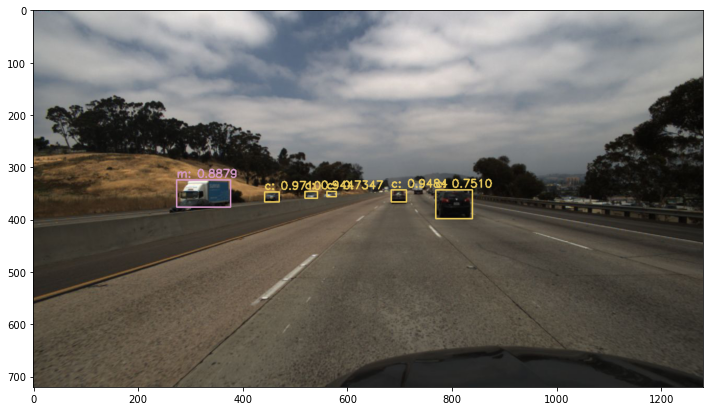

In [31]:
plt.imshow(img)

In [32]:
print(bboxes)

[[442, 347, 28, 19], [684, 343, 29, 23], [519, 346, 24, 13], [274, 324, 103, 52], [769, 343, 70, 55], [561, 346, 18, 10]]


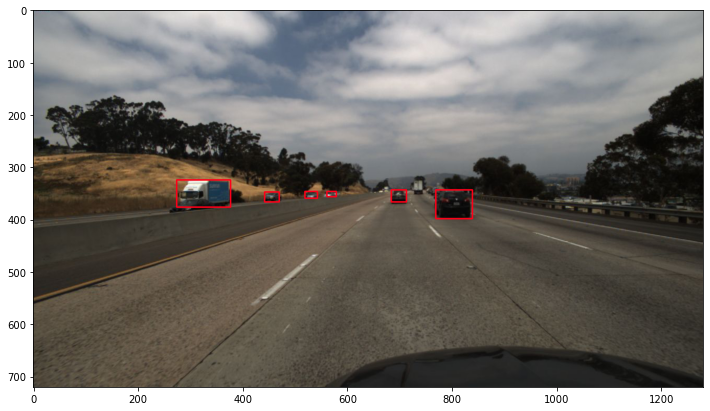

In [33]:
# test 2: taking the original version of the image and painting bounding boxes manually
# to ensure can use bounding boxes separately
img_clean = cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)
color = [255,0,25]
for box in bboxes:
    x,y,w,h = box
    cv2.rectangle(img_clean, (x,y) , (x+w , y+h) ,color, 2)

plt.imshow(img_clean)

<hr>
Till above, have managed to accurately get bounding boxes (after non-maximum suppression) for a file. Now get bounding boxes for multiple images in a clip, so can use tracking


In [34]:
folder = r"C:\\Users\\usama\\anaconda3\\envs\\COMP_9517_Project\\COMP_9517_Project\\Data\\benchmark_velocity_train\\clips\\"
#folder = r"C:\\Users\\UttkarshSharma\\Downloads\\benchmark_velocity_train\\clips\\" # note starts with .. 
#folder = '../velocity/benchmark_velocity_train/clips/' # (velocity is in parent folder, not this folder)
clipnum = 32

yololo = YOLO_custom()

imgpaths = []
resultimgs = []
bboxset = []
for file in range (30,41): # currently debugging bbox error. Can increase range later
    imgpaths.append(yololo.setandgetPath(folder,clipnum,file))
    resultimg, bboxes = yololo.YOLO_bboxes (folder, clipnum, file)
    resultimgs.append(resultimg)
#     print("DEBUG, bboxes is", bboxes)
    bboxset.append(bboxes.copy()) # using copy() here removed the bug, finally
#     print("DEBUG, accumulator bboxset has", bboxset)

[INFO] YOLO took 0.526316 seconds
[INFO] YOLO took 0.373001 seconds
[INFO] YOLO took 0.388962 seconds
[INFO] YOLO took 0.384521 seconds
[INFO] YOLO took 0.410431 seconds
[INFO] YOLO took 0.414890 seconds
[INFO] YOLO took 0.376506 seconds
[INFO] YOLO took 0.375803 seconds
[INFO] YOLO took 0.381491 seconds
[INFO] YOLO took 0.410876 seconds
[INFO] YOLO took 0.383131 seconds


In [35]:
# display these bounding boxed images, as returned by the function
NUMRUNS = 100

font = cv2.FONT_HERSHEY_SIMPLEX
for numruns in range(NUMRUNS): # will run the following many times unless Esc key pressed (safer than while True)
    for imgres in resultimgs:
        img = imgres.copy()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.putText(img,'Press Esc to quit',(10,20), font, 0.5, (255,0,0), 1 ,cv2.LINE_AA)
        cv2.putText(img,'Clip '+str(clipnum),(20,img.shape[0]-20), font, 0.5, (255,0,0), 1 ,cv2.LINE_AA)
        
        cv2.imshow("Clip",img)
                
        key = cv2.waitKey(50) # milliseconds wait. We are told is 20 frames per second, so 50 milliseconds per frame
        if key == 27 or key == 32: # Esc key breaks everything, space key restarts only this loop
            break # break out of this for loop
    if key == 27:
        break # break out of outer loop
cv2.destroyAllWindows()
# misc tip: If want to force clip to always run in foreground, this page has a hack
# https://stackoverflow.com/questions/8417531/opencv-how-to-force-the-image-window-to-appear-on-top-of-other-windows#8417890



In [36]:
# display the original images and paint bounding boxes manually on every frame
# for testing and comparison with the above
NUMRUNS = 100

font = cv2.FONT_HERSHEY_DUPLEX
for numruns in range(NUMRUNS): # will run the following many times unless Esc key pressed (safer than while True)
    for imgpath, boxes in zip(imgpaths, bboxset):
        orgimg = cv2.imread(imgpath) # zfill will add leading zeros to make total width 3
        img = orgimg.copy() # since would write text on it, making a copy
        
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.putText(img,'Press Esc to quit',(10,20), font, 0.5, (255,0,0), 1 ,cv2.LINE_AA)
        cv2.putText(img,'Clip '+str(clipnum),(20,img.shape[0]-20), font, 0.5, (255,0,0), 1 ,cv2.LINE_AA)
        for box in boxes:
            x,y,w,h = box
            cv2.rectangle(img, (x,y) , (x+w , y+h) ,color, 2)
        cv2.imshow("Clip",img)
        
        key = cv2.waitKey(50) # milliseconds wait. We are told is 20 frames per second, so 50 milliseconds per frame
        if key == 27 or key == 32: # Esc key breaks everything, space key restarts only this loop
            break # break out of this for loop
    if key == 27:
        break # break out of outer loop
cv2.destroyAllWindows()


Above works. Now implement tracker

In [37]:
import math

# adapted from original work courtesy Sergio Canu, pysource.com
# uses Euclidean distance to determine if a bounding box is the same one or different 
class EuclideanDistTracker:
    def __init__(self):
        # Store the center positions of the objects
        self.center_points = {}
        # Keep the count of the IDs
        # each time a new object id detected, the count will increase by one
        self.id_count = 0
        self.thresh = 25 # distance threshold within which it's supposed to be the
        # same bounding box

    def setThresh(self, thresh):
        self.thresh = thresh
        
    def getThresh(self, thresh):
        return self.thresh
    
    def update(self, objects_rect):
        # Objects boxes and ids
        objects_bbs_ids = []

        # Get center point of new object
        for rect in objects_rect:
            x, y, w, h = rect
            cx = (x + x + w) // 2
            cy = (y + y + h) // 2

            # Find out if that object was detected already
            same_object_detected = False
            for id, pt in self.center_points.items():
                dist = math.hypot(cx - pt[0], cy - pt[1])

                if dist < self.thresh:
                    self.center_points[id] = (cx, cy)
#                     print(self.center_points)
                    objects_bbs_ids.append([x, y, w, h, id])
                    same_object_detected = True
                    break

            # New object is detected we assign the ID to that object
            if same_object_detected is False:
                self.center_points[self.id_count] = (cx, cy)
                objects_bbs_ids.append([x, y, w, h, self.id_count])
                self.id_count += 1

        # Clean the dictionary by center points to remove IDS not used anymore
        new_center_points = {}
        for obj_bb_id in objects_bbs_ids:
            _, _, _, _, object_id = obj_bb_id
            center = self.center_points[object_id]
            new_center_points[object_id] = center

        # Update dictionary with IDs not used removed
        self.center_points = new_center_points.copy()
        return objects_bbs_ids
    

In [38]:
tracker = EuclideanDistTracker()
tracker.setThresh(50) # pixel distance threshold within which it is taken
            # to be the same bounding box. Euclidean distance between center of bounding boxes
            # Value has to be tweaked. Default of 25 couldn't handle fast cars (opposite direction)

In [39]:
# print(tracker)

In [40]:
# bboxset[0]

In [41]:
# tracker.update(bboxset[3])

#### The prediction of the distance and velocity is done here


In [42]:
###creation of the data is being done here for the model

X_train_list = []
Y_train_list = []

#parameter = ""

## this is for the input to the model
def extract_bbox_coords(clip_number):
    
        global X_train_list 

        file_name = "annotation.json"
        path_dir = "C:\\Users\\usama\\anaconda3\\envs\\COMP_9517_Project\\COMP_9517_Project\\Data\\benchmark_velocity_train\\clips\\" + str(clip_number) + "\\"
        #path_dir = "C:\\Users\\UttkarshSharma\\Downloads\\benchmark_velocity_train\\clips\\" + str(clip_number) + "\\"
        #path_dir = '../velocity/benchmark_velocity_train/clips/'+str(clip_number)+'/' # (velocity is in parent folder, not this folder)
        f = open(path_dir+file_name)

        annotations_img = json.load(f)

        f.close()

        X_train_temp = []

        for j in range(len(annotations_img)):

            img_top = annotations_img[j]['bbox']['top']

            img_right = annotations_img[j]['bbox']['right']

            img_bottom = annotations_img[j]['bbox']['bottom']

            img_left = annotations_img[j]['bbox']['left']

            #img_position_x = annotations_img[0]['position'][0]

            #img_position_y = annotations_img[0]['position'][1]

            X_train_temp.append(img_top)

            X_train_temp.append(img_right)

            X_train_temp.append(img_bottom)

            X_train_temp.append(img_left)

            X_train_list.append(X_train_temp)

            X_train_temp = []



In [43]:
## for the output to the model

#the parameter variable is used for getting either the distance target or the veloctiy target
def extract_position_coords(parameter,clip_number):
    
        global Y_train_list 
        file_name = "annotation.json"
        path_dir = "C:\\Users\\usama\\anaconda3\\envs\\COMP_9517_Project\\COMP_9517_Project\\Data\\benchmark_velocity_train\\clips\\" + str(clip_number) + "\\"
        #path_dir = "C:\\Users\\UttkarshSharma\\Downloads\\benchmark_velocity_train\\clips\\" + str(clip_number) + "\\"
        #path_dir = '../velocity/benchmark_velocity_train/clips/'+str(clip_number)+'/' # (velocity is in parent folder, not this folder)
        f = open(path_dir+file_name)

        annotations_img = json.load(f)

        f.close()

        Y_train_temp = []
        
        for j in range(len(annotations_img)):

            img_position_x = annotations_img[j][parameter][0]

            img_position_y = annotations_img[j][parameter][1]

            Y_train_temp.append(img_position_x)

            Y_train_temp.append(img_position_y)

            Y_train_list.append(Y_train_temp)

            Y_train_temp = []
    
    #getting the target values here
    


In [44]:
## here we will create input and out put for our models both for distance and velocity


for i in range(1,1075):
    extract_bbox_coords(i)
    
for i in range(1,1075):
        extract_position_coords("position", i)


In [45]:


def prediction_mo(X_train_list,Y_train_list):
    
    #now we will get the numpy order for the target and the input for our prediction model
    X_train = np.array(X_train_list)
    Y_train = np.array(Y_train_list)
    
    xtrain, xtest, ytrain, ytest = train_test_split(X_train, Y_train, test_size=0.15)
    
    #the model is being created here
    
    model = Sequential()
    model.add(Dense(100, input_dim=4, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(2))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics = ["mean_squared_error"])
    
    #this is the summary of the model
    model.summary()
    
    #this here is being fit on the training data set.
    model.fit(xtrain, ytrain, epochs=300, batch_size=20, verbose=0)
    evalmodel = model.evaluate(xtest, ytest)
    
    
#     #this is test check on the training dataset
#     pred = model.predict(X_train)
    
#     #for checking the accuracy of the model for the test data set.
#     pred_eval = abs(Y_train - pred)
    
#     pred_eval[np.where(pred_eval > 5)].shape
    
#     #this is +-5 px range of error and for checking how accurate our predictions are.
#     print((pred_eval.shape[0] - ( pred_eval[np.where(pred_eval > 5)].shape[0] )) / (pred_eval.shape[0]))
    
    return model
    
    
    
#now if we change the "distance to velocity it will run for velocity and create the model"
#### the model runs something like this

## (input is bounding box) and ouput is distance/velocity[x,y] co-ordinates.


In [46]:
distance_model = prediction_mo(X_train_list, Y_train_list)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               500       
_________________________________________________________________
dense_8 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 66        
Total params: 3,798
Trainable params: 3,798
Non-trainable params: 0
_________________________________________________________________
217/217 [==============================] - 0s 106us/step


In [47]:
### Now making the code for the velocity model 

Y_train_list = []

for i in range(1,1075):
        extract_position_coords("velocity", i)
        


In [48]:
velocity_model = prediction_mo(X_train_list, Y_train_list)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               500       
_________________________________________________________________
dense_11 (Dense)             (None, 32)                3232      
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 66        
Total params: 3,798
Trainable params: 3,798
Non-trainable params: 0
_________________________________________________________________
217/217 [==============================] - 0s 124us/step


In [49]:
import pandas as pd

top = 349
left = 651

width = 31
height = 26

bottom = top + height
right = left + width 

tst_input = pd.DataFrame([top,right, bottom, left])

In [50]:
trans = tst_input.T

In [51]:
trans.shape

(1, 4)

In [52]:
distance_model.predict(trans)

array([[50.909584 , -1.6688926]], dtype=float32)

In [ ]:
# display the frames, paint bounding boxes manually, and show tracking ids or other info 
NUMRUNS = 100
colorbox = (240,0,24)
colortext = (0, 240, 0)
font = cv2.FONT_HERSHEY_SIMPLEX

for numruns in range(NUMRUNS): # will run the following many times unless Esc key pressed (safer than while True)
    for imgpath, boxes in zip(imgpaths, bboxset):
        orgimg = cv2.imread(imgpath) # zfill will add leading zeros to make total width 3
        img = orgimg.copy() # since would write text on it, making a copy
        
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.putText(img,'Press Esc to quit',(10,20), font, 0.5, (255,0,0), 1 ,cv2.LINE_AA)
        cv2.putText(img,'Clip '+str(clipnum),(20,img.shape[0]-20), font, 0.5, (255,0,0), 1 ,cv2.LINE_AA)
        
        boxes_ids = tracker.update(boxes)
        for box_id in boxes_ids:
            #print(box_id)
            x, y, w, h, id = box_id
            
            ##here i think you will predict the model for distance and velocity 
            ## then plot the data, but not too sure, hence left blank
            
            ##### the co-ordinates need to be checked here if they are the same as that we are training them to be
            ### distance prediction is being done here
            
#             top = 349
#             left = 651

#             width = 31
#             height = 26

            top = y
            left = x
            
            bottom = top + h
            right = left + w
            
            ## this section is for the input to the model
            test_input = pd.DataFrame([top,right,  bottom, left])
            shaping_input = test_input.T
            
            
            ### this is the prediction of the distance
            distance_pred = distance_model.predict(shaping_input)
            
            #this is the velocity prediction
            velocity_pred = velocity_model.predict(shaping_input)
            
            x_dis = round(distance_pred[0][0],2)
            y_dis = round(distance_pred[0][1],2)
            
            ## co-ordinates for the velocity prediction
            x_velo = round(velocity_pred[0][0],2)
            v_velo = round(velocity_pred[0][1],2)
            
            # this will put text above the bounding box (y-15). x-coordinate [0][0], y-coordinate [0][1]
            cv2.putText(img, "D:"+str(x_dis)+', '+str(y_dis), (x, y - 15), font, 0.5, colortext , 1)
            
            # the following should work,
            # Adjust the x+n to move it further to the right/left if needed. Use {.4f} etc to pre-define width
            #cv2.putText(img, str(distance_pred[0][1]), (x+30, y - 15), font, 0.5, colortext , 2)
            # this paints the bounding box
            cv2.rectangle(img, (x, y), (x + w, y + h), colorbox, 2)
            # this puts text below the bounding box, for velocity, adjust the n in the y+h +n for height
            cv2.putText(img, "V:"+str(x_velo)+', '+str(v_velo), (x, y+h + 30), font, 0.5, colortext , 1)
            
        
        cv2.imshow("Clip",img)
        
        key = cv2.waitKey(50) # milliseconds wait. We are told is 20 frames per second, so 50 milliseconds per frame
        if key == 27 or key == 32: # Esc key breaks everything, space key restarts only this loop
            break # break out of this for loop
    if key == 27:
        break # break out of outer loop
cv2.destroyAllWindows()
